In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast_pitcher, playerid_lookup, statcast
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
peralta = statcast_pitcher('2022-03-30', '2023-11-06', 642547)
all = statcast('2022-03-30', '2023-11-06')

Gathering Player Data
This is a large query, it may take a moment to complete


/opt/homebrew/lib/python3.11/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates


100%|██████████| 468/468 [01:00<00:00,  7.79it/s]


In [3]:
peralta.dropna(subset='pitch_type', axis=0, inplace=True)
all.dropna(subset='pitch_type', axis=0, inplace=True)

In [4]:
unique_pitch_types = peralta.pitch_type.unique()

In [5]:
bottom_strike_zone = 1.52166
top_strike_zone = 3.67333
left_strike_zone = -0.83083
right_strike_zone = 0.83083

early = [(0,0), (1,0), (0,1), (1,1)]
ahead = [(2,0), (3,1), (3,0), (2,1)]
two_k = [(0,2), (1,2), (2,2), (3,2)]

In [6]:
def classify_count(row):
    count = (row['balls'], row['strikes'])
    if count in early:
        return "Early"
    elif count in ahead:
        return "Ahead"
    elif count in two_k:
        return "2K"
    else:
        return np.nan

peralta['qual_count'] = peralta.apply(classify_count, axis=1)
all['qual_count'] = all.apply(classify_count, axis=1)

In [7]:
target_cols = ['pitch_type', 'pitch_percent', 'release_speed', 'effective_speed', 'release_spin_rate', 'release_extension', 'pfx_x', 'pfx_z', 'estimated_woba_using_speedangle']

In [8]:
def manip_df(df, qual_count):
    if qual_count != None:
        df = df[df.qual_count == qual_count].drop('qual_count', axis=1)
    total = df.num_pitches.sum()
    df['pitch_percent'] = ((df.num_pitches / total).round(3) * 100).round(1)
    df = df[['pitch_type', 'pitch_percent', 'release_speed', 'effective_speed', 'release_spin_rate', 'release_extension', 'pfx_x', 'pfx_z', 'estimated_woba_using_speedangle']]
    df.rename(columns={'pitch_type': 'Pitch Type', 
                       'pitch_percent': 'Pitch%', 
                       'release_speed': 'Speed', 
                       'effective_speed': 'Effective Speed', 
                       'release_spin_rate': 'Spin', 
                       'release_extension': 'Extension',
                       'pfx_x': 'HB',
                       'pfx_z': 'VB',
                       'estimated_woba_using_speedangle': 'xwOBA'}, inplace=True)
    return df

In [9]:
stand_df = peralta[peralta.stand == 'R']
group_sizes = stand_df.groupby(['pitch_type', 'qual_count']).size().reset_index(name='num_pitches')
grouped_df = stand_df.groupby(['pitch_type', 'qual_count'])[['release_speed', 'effective_speed', 'release_spin_rate', 'release_extension', 'pfx_x', 'pfx_z', 'estimated_woba_using_speedangle']].mean() \
    .reset_index() \
    .merge(group_sizes, on=['pitch_type', 'qual_count'])
grouped_df[['pfx_x', 'pfx_z']] = grouped_df[['pfx_x', 'pfx_z']] * 12
grouped_df[['release_speed', 'effective_speed', 'pfx_x', 'pfx_z', 'release_extension']] = grouped_df[['release_speed', 'effective_speed', 'pfx_x', 'pfx_z', 'release_extension']].round(2)
grouped_df[['estimated_woba_using_speedangle']] = grouped_df[['estimated_woba_using_speedangle']].round(3)
grouped_df.release_spin_rate = grouped_df.release_spin_rate.round().astype(int)

early_grouped_df = manip_df(grouped_df, 'Early').sort_values(by='Pitch%', ascending=False)
ahead_grouped_df = manip_df(grouped_df, 'Ahead').sort_values(by='Pitch%', ascending=False)
two_k_grouped_df = manip_df(grouped_df, '2K').sort_values(by='Pitch%', ascending=False)

In [10]:
all_stand_df = all[all.stand == 'R']
all_group_sizes = all_stand_df.groupby(['pitch_type', 'qual_count']).size().reset_index(name='num_pitches')
all_grouped_df = all_stand_df.groupby(['pitch_type', 'qual_count'])[['release_speed', 'effective_speed', 'release_spin_rate', 'release_extension', 'pfx_x', 'pfx_z', 'estimated_woba_using_speedangle']].mean() \
    .reset_index() \
    .merge(all_group_sizes, on=['pitch_type', 'qual_count'])
all_grouped_df[['pfx_x', 'pfx_z']] = all_grouped_df[['pfx_x', 'pfx_z']] * 12
all_grouped_df[['release_speed', 'effective_speed', 'pfx_x', 'pfx_z', 'release_extension']] = all_grouped_df[['release_speed', 'effective_speed', 'pfx_x', 'pfx_z', 'release_extension']].round(2)
all_grouped_df[['estimated_woba_using_speedangle']] = all_grouped_df[['estimated_woba_using_speedangle']].round(3)
all_grouped_df.release_spin_rate = all_grouped_df.release_spin_rate.round().astype(int)

all_grouped_df = manip_df(all_grouped_df, None).sort_values(by='Pitch%', ascending=False)

/var/folders/c6/hld85jsx0k97x9603_dq35_80000gn/T/ipykernel_20224/2723199899.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'pitch_type': 'Pitch Type',


In [13]:
all.reset_index(inplace=True)

In [14]:
all.drop('index', axis=1, inplace=True)

In [15]:
all[['pfx_x', 'pfx_z']] = all[['pfx_x', 'pfx_z']] * 12

In [16]:
def apply_quantile_colormap(value, series):
    value = float(value)
    # Calculate the absolute differences and sort to find the closest value
    diffs = (series - value).abs()
    closest_index = diffs.idxmin()  # Get the index of the closest value
    # print(closest_index)
    # Calculate the relative position of the closest value in the series quantiles
    quantile_position = series.rank(pct=True)[closest_index]
    # print(quantile_position)
    return plt.cm.coolwarm(quantile_position)

In [19]:
def create_one_sheeter(pdf):
    fig = plt.figure(figsize=(16, 8))

    columns = ['Pitch\nType', 'Pitch%', 'Speed', 'Effective\nSpeed', 'Spin', 'Extension',
            'HB', 'VB', 'xwOBA']

    cell_height = 0.45

    plt.figtext(0.11, 0.9, 'Early Count', ha='left', va='top', c='black', fontsize=12)

    ax1 = fig.add_axes([0.05, 0.7, 0.2, 0.1])
    table1 = ax1.table(cellText=early_grouped_df.values,
                    colLabels=columns,
                    loc='center',
                    cellLoc='left',
                    rowLoc='left')
    table1.auto_set_font_size(False)
    table1.set_fontsize(10)
    table1.auto_set_column_width(col=list(range(len(columns))))
    for (row, col), cell in table1.get_celld().items():
        cell.set_height(cell_height)
        if row > 0 and col > 1:
            ptype = early_grouped_df.iloc[row-1, 0]
            series = all[all['pitch_type'] == ptype][target_cols[col]]
            # print(series)
            value = early_grouped_df.iloc[row-1, col]
            # print(value)
            # Apply the quantile colormap
            cell_color = apply_quantile_colormap(value, series)
            # print(cell_color)
            cell.set_facecolor(cell_color)
            # Adjust text color for visibility
            cell.set_text_props(color='black' if np.mean(cell_color[:3]) > 0.5 else 'white')


    ax2_area = [0.00005, 0.5, 0.3, 0.1]
    ax2_grid = plt.GridSpec(1, 4, fig, left=ax2_area[0], bottom=ax2_area[1], right=ax2_area[0]+ax2_area[2], top=ax2_area[1]+ax2_area[3])

    heatmap_df = stand_df[stand_df.qual_count == 'Early']
    idx = 0
    for j in range(4):
        ptype = unique_pitch_types[idx]
        ptype_data = heatmap_df[heatmap_df.pitch_type == ptype]
        ax2_sub = fig.add_subplot(ax2_grid[0, j])
        sns.kdeplot(data=ptype_data, x='plate_x', y='plate_z', 
                fill=True, cmap='coolwarm',
                cbar=False, cbar_kws={'label': 'Density'},
                bw_adjust=0.75)
        ax2_sub.plot([left_strike_zone, right_strike_zone, right_strike_zone, left_strike_zone, left_strike_zone],
            [bottom_strike_zone, bottom_strike_zone, top_strike_zone, top_strike_zone, bottom_strike_zone], 
            color='black', linestyle='-', linewidth=2)

        ax2_sub.plot([left_strike_zone, right_strike_zone, right_strike_zone, (left_strike_zone+right_strike_zone)/2, left_strike_zone, left_strike_zone],
            [.2, .2, 0, -.2, 0, .2], 
            color='black', linestyle='-', linewidth=2)
        ax2_sub.set_aspect('equal')
        ax2_sub.set_xlim(-2.5, 2.5)
        ax2_sub.set_ylim(-1, 5)
        ax2_sub.set_xlabel('')
        ax2_sub.set_ylabel('')     
        ax2_sub.set_xticks([])
        ax2_sub.set_yticks([])
        ax2_sub.set_title(ptype)

        idx += 1


    plt.figtext(0.11, 0.4, "Hitter's Count", ha='left', va='top', c='black', fontsize=12)
        
    ax3 = fig.add_axes([0.05, 0.2, 0.2, 0.1])
    table3 = ax3.table(cellText=ahead_grouped_df.values,
                    colLabels=columns,
                    loc='center',
                    cellLoc='left',
                    rowLoc='left')
    table3.auto_set_font_size(False)
    table3.set_fontsize(10)
    table3.auto_set_column_width(col=list(range(len(columns))))
    for (row, col), cell in table3.get_celld().items():
        cell.set_height(cell_height)
        if row > 0 and col > 1:
            ptype = ahead_grouped_df.iloc[row-1, 0]
            series = all[all['pitch_type'] == ptype][target_cols[col]]
            # print(series)
            value = ahead_grouped_df.iloc[row-1, col]
            # print(value)
            # Apply the quantile colormap
            cell_color = apply_quantile_colormap(value, series)
            # print(cell_color)
            cell.set_facecolor(cell_color)
            # Adjust text color for visibility
            cell.set_text_props(color='black' if np.mean(cell_color[:3]) > 0.5 else 'white')



    ax4_area = [0.00005, 0, 0.3, 0.1]
    ax4_grid = plt.GridSpec(1, 4, fig, left=ax4_area[0], bottom=ax4_area[1], right=ax4_area[0]+ax4_area[2], top=ax4_area[1]+ax4_area[3])

    heatmap_df = stand_df[stand_df.qual_count == 'Ahead']
    idx = 0
    for j in range(4):
        ptype = unique_pitch_types[idx]
        ptype_data = heatmap_df[heatmap_df.pitch_type == ptype]
        ax4_sub = fig.add_subplot(ax4_grid[0, j])
        sns.kdeplot(data=ptype_data, x='plate_x', y='plate_z', 
                fill=True, cmap='coolwarm',
                cbar=False, cbar_kws={'label': 'Density'},
                bw_adjust=0.75)
        ax4_sub.plot([left_strike_zone, right_strike_zone, right_strike_zone, left_strike_zone, left_strike_zone],
            [bottom_strike_zone, bottom_strike_zone, top_strike_zone, top_strike_zone, bottom_strike_zone], 
            color='black', linestyle='-', linewidth=2)

        ax4_sub.plot([left_strike_zone, right_strike_zone, right_strike_zone, (left_strike_zone+right_strike_zone)/2, left_strike_zone, left_strike_zone],
            [.2, .2, 0, -.2, 0, .2], 
            color='black', linestyle='-', linewidth=2)
        ax4_sub.set_aspect('equal')
        ax4_sub.set_xlim(-2.5, 2.5)
        ax4_sub.set_ylim(-1, 5)
        ax4_sub.set_xlabel('')
        ax4_sub.set_ylabel('')     
        ax4_sub.set_xticks([])
        ax4_sub.set_yticks([])
        ax4_sub.set_title(ptype)

        idx += 1



    plt.figtext(0.62, 0.9, '2K Count', ha='left', va='top', c='black', fontsize=12)

    ax5 = fig.add_axes([0.55, 0.7, 0.2, 0.1])
    table5 = ax5.table(cellText=two_k_grouped_df.values,
                    colLabels=columns,
                    loc='center',
                    cellLoc='left',
                    rowLoc='left')
    table5.auto_set_font_size(False)
    table5.set_fontsize(10)
    table5.auto_set_column_width(col=list(range(len(columns))))
    for (row, col), cell in table5.get_celld().items():
        cell.set_height(cell_height)
        if row > 0 and col > 1:
            ptype = two_k_grouped_df.iloc[row-1, 0]
            series = all[all['pitch_type'] == ptype][target_cols[col]]
            # print(series)
            value = two_k_grouped_df.iloc[row-1, col]
            # print(value)
            # Apply the quantile colormap
            cell_color = apply_quantile_colormap(value, series)
            # print(cell_color)
            cell.set_facecolor(cell_color)
            # Adjust text color for visibility
            cell.set_text_props(color='black' if np.mean(cell_color[:3]) > 0.5 else 'white')


    ax6_area = [0.5, 0.5, 0.3, 0.1]
    ax6_grid = plt.GridSpec(1, 4, fig, left=ax6_area[0], bottom=ax6_area[1], right=ax6_area[0]+ax6_area[2], top=ax6_area[1]+ax6_area[3])

    heatmap_df = stand_df[stand_df.qual_count == '2K']
    idx = 0
    for j in range(4):
        ptype = unique_pitch_types[idx]
        ptype_data = heatmap_df[heatmap_df.pitch_type == ptype]
        ax6_sub = fig.add_subplot(ax6_grid[0, j])
        sns.kdeplot(data=ptype_data, x='plate_x', y='plate_z', 
                fill=True, cmap='coolwarm',
                cbar=False, cbar_kws={'label': 'Density'},
                bw_adjust=0.75)
        ax6_sub.plot([left_strike_zone, right_strike_zone, right_strike_zone, left_strike_zone, left_strike_zone],
            [bottom_strike_zone, bottom_strike_zone, top_strike_zone, top_strike_zone, bottom_strike_zone], 
            color='black', linestyle='-', linewidth=2)

        ax6_sub.plot([left_strike_zone, right_strike_zone, right_strike_zone, (left_strike_zone+right_strike_zone)/2, left_strike_zone, left_strike_zone],
            [.2, .2, 0, -.2, 0, .2], 
            color='black', linestyle='-', linewidth=2)
        ax6_sub.set_aspect('equal')
        ax6_sub.set_xlim(-2.5, 2.5)
        ax6_sub.set_ylim(-1, 5)
        ax6_sub.set_xlabel('')
        ax6_sub.set_ylabel('')     
        ax6_sub.set_xticks([])
        ax6_sub.set_yticks([])
        ax6_sub.set_title(ptype)

        idx += 1


    plt.figtext(0.62, 0.4, 'Movement Profiles', ha='left', va='top', c='black', fontsize=12)

    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_pitch_types)))
    color_map = dict(zip(unique_pitch_types, colors))

    ax7 = fig.add_axes([0.5, 0, 0.35, 0.35])
    ax7.scatter(stand_df.pfx_x*12, stand_df.pfx_z*12, c=stand_df['pitch_type'].map(color_map))
    ax7.grid(True)
    ax7.set_aspect('equal')
    legend_labels = {pitch_type: color for pitch_type, color in zip(unique_pitch_types, colors)}
    markers = [plt.Line2D([0], [0], color=color, marker='o', linestyle='') for color in legend_labels.values()]
    ax7.legend(markers, legend_labels.keys(), title="Pitch Types")

            
    for ax in [ax1, ax3, ax5]:
        ax.axis('off')
        ax.set_frame_on(False)
        
        
    plt.figtext(0.29, 0.95, 'Freddy Peralta Versus Righties', ha='left', va='top', c='black', fontsize=15, fontweight='bold')

    pdf.savefig(fig, dpi=100, bbox_inches='tight')
    plt.show()
    plt.close(fig)


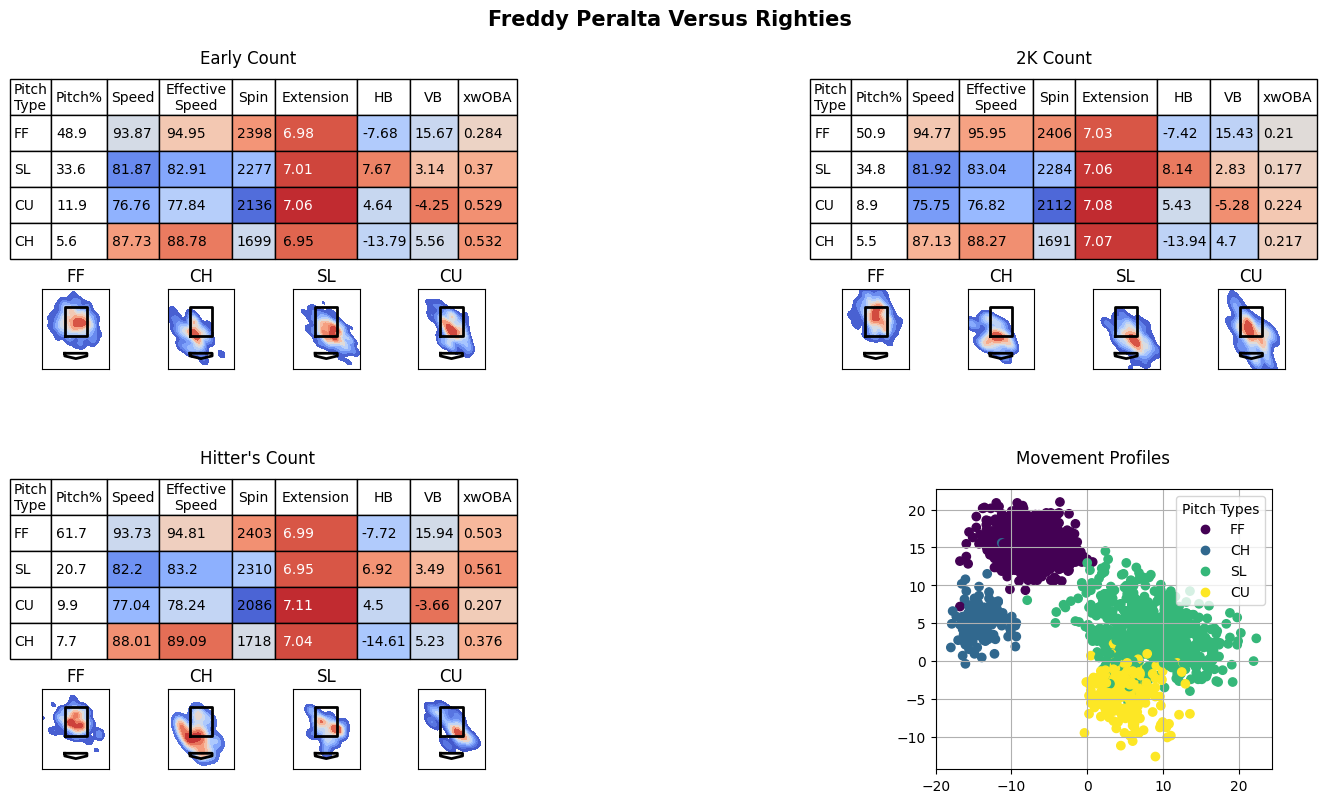

In [20]:
pdf = PdfPages('/Users/gabriellevy/Documents/freddy_peralta_adv_report.pdf')
create_one_sheeter(pdf)
pdf.close()